# Mutation Pipeline

In [5]:
from __future__ import print_function
import os.path
import pandas as pd
import gzip
import sys
import numpy as np

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import Datanalytics as da 
from JKBio import TerraFunction as terra
from JKBio import Helper as h
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display



%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

you need to have installed JKBio in the same folder as ccle_processing


Loading BokehJS ...

## boot up

we are instanciating all the parameters needed for this pipeline to run

In [6]:
samplesetname = "20Q3"
prevname="20Q2"
prevversion = 22
prevprevname ='20Q1'
prevprevversion= 20
virtual_internal='internal-20q3-00d0'

refworkspace="broad-firecloud-ccle/DepMap_Mutation_Calling_CGA_pipeline"



refsheet_url = "https://docs.google.com/spreadsheets/d/1XkZypRuOEXzNLxVk9EOHeWRE98Z8_DBvL4PovyM01FE"
sheeturl = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

release = samplesetname

In [7]:
%%R
release <- '20Q3'
prevname <- '20Q2'
genome_version <- 'hg19'
taiga_version <- 10
prevversion <-13

In [5]:
refwm = dm.WorkspaceManager(refworkspace)

In [7]:
res = refwm.get_sample_sets().loc["all"]
res

filtered_CGA_MAF_aggregated    gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
samples                        [CDS-00rz9N, CDS-01bI6z, CDS-02waxZ, CDS-04TUV...
merged_mutations               gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
Name: all, dtype: object

In [8]:
filtered = res['filtered_CGA_MAF_aggregated']
! gsutil cp $filtered "temp/mutation_filtered_terra_merged.txt"

Copying gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b76b912/b49f7c3a-3f14-49e4-a464-006490d4a37b/aggregateMAFs_selectFields_workflow/66076582-bcd7-44d9-bfde-ee81bcb677e9/call-aggregateMAFs_selectFields/all.mergedMAF.txt...
/ [1 files][253.5 MiB/253.5 MiB]                                                
Operation completed over 1 objects/253.5 MiB.                                    


In [9]:
file = pd.read_csv('temp/mutation_filtered_terra_merged.txt',sep='\t') 
print(file.columns[:10])
renaming = removeOlderVersions(names = set(file['Tumor_Sample_Barcode']), refsamples = refwm.get_samples(), arxspan_id = "arxspan_id", version="version")
print(file[file['Chromosome']=='0'])
file[file['Tumor_Sample_Barcode'].isin(renaming.keys())].replace({'Tumor_Sample_Barcode':renaming}).reset_index(drop=True).to_csv('temp/mutation_filtered_terra_merged.txt',sep='\t',index=None)

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_position', 'End_position', 'Strand', 'Variant_Classification',
       'Variant_Type'],
      dtype='object')
removed 247 duplicate samples
Empty DataFrame
Columns: [Hugo_Symbol, Entrez_Gene_Id, Center, NCBI_Build, Chromosome, Start_position, End_position, Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, dbSNP_RS, dbSNP_Val_Status, Genome_Change, Annotation_Transcript, Tumor_Sample_Barcode, cDNA_Change, Codon_Change, Protein_Change, t_alt_count, t_ref_count, tumor_f, isDeleterious, isTCGAhotspot, TCGAhsCnt, isCOSMIChotspot, COSMIChsCnt, i_ExAC_AF, PASS]
Index: []

[0 rows x 31 columns]


In [19]:
ls ../JKBio/

CCLF_processing.py         helper/                requirements.txt
cell_line_mapping-master/  Helper.py              RScript.R
data/                      __init__.py            setup.py
Datanalytics.py            LICENSE                taigr/
epigenetics/               my_custom_commands.sh  TerraFunction.py
GCPFunction.py             __pycache__/
generate_sample_info.sh    README.md


In [57]:
%%R
#source('src/load_libraries_and_annotations.R')
load('src/Annotations.rdata') 
# There are some cell lines the celllinemapr does not know how to map so we need to load this data object for now (from old datasets)
source('src/CCLE_postp_function.R')
library('cdsomics')
library(tidyverse)
library(data.table)
library(magrittr)
library(taigr)
library(cdsomics)
library(celllinemapr) # To pull out DepMap_IDs from CCLE_names where needed

In [24]:
%%R
newly_merged_maf <- readMutations('temp/mutation_filtered_terra_merged.txt')
new_release <- createSNPs(newly_merged_maf)
names(new_release)

 [1] "Hugo_Symbol"            "Entrez_Gene_Id"         "NCBI_Build"            
 [4] "Chromosome"             "Start_position"         "End_position"          
 [7] "Strand"                 "Variant_Classification" "Variant_Type"          
[10] "Reference_Allele"       "Tumor_Seq_Allele2"      "dbSNP_RS"              
[13] "dbSNP_Val_Status"       "Genome_Change"          "Annotation_Transcript" 
[16] "Tumor_Sample_Barcode"   "cDNA_Change"            "Codon_Change"          
[19] "Protein_Change"         "isDeleterious"          "isTCGAhotspot"         
[22] "TCGAhsCnt"              "isCOSMIChotspot"        "COSMIChsCnt"           
[25] "t_alt_count"            "t_ref_count"            "ExAC_AF"               
[28] "pass"                  


In [29]:
%%R
new_release <- renameAsInMainMutation(new_release)

In [58]:
%%R
filtered <- filterAllelicFraction(new_release)

[1] 1002964      29


In [63]:
%%R
write.table(
  filtered$merged, 
  paste0('temp/newmutations.', release, '.all.csv'), sep = ',', quote = F, row.names = F)

In [59]:
%%R
filtered <- filterMinCoverage(filtered$merged, filtered$removed_from_maf)

R[write to console]: Error in `[.data.frame`(merged_latest_release, , c("CGA_WES_AC", "WGS_AC",  : 
  undefined columns selected
Calls: <Anonymous> ... withVisible -> filterMinCoverage -> apply -> [ -> [.data.frame

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In FUN(newX[, i], ...) :
R[write to console]:  NAs introduced by coercion

R[write to console]: 2: 
R[write to console]: In FUN(newX[, i], ...) :
R[write to console]:  NAs introduced by coercion




Error in `[.data.frame`(merged_latest_release, , c("CGA_WES_AC", "WGS_AC",  : 
  undefined columns selected
Calls: <Anonymous> ... withVisible -> filterMinCoverage -> apply -> [ -> [.data.frame


In [ ]:
%%R
head(merged)

In [ ]:
%%R
clean_annotations <- mergeAnnotations(merged,previous.release.maf)

In [ ]:
%%R

# Allie's version
new_release <- addAnnotation(new_release)

In [ ]:
%%R
# some matric files that does get used internaly and might be useful
damaging_mutation <- mutation_maf_to_binary_matrix(new_release, damaging =  TRUE)
other_mutation <- mutation_maf_to_binary_matrix(new_release, other = TRUE)
hotspot_mutation <- mutation_maf_to_binary_matrix(new_release, hotspot = TRUE)

In [ ]:
%%R
# Save the ready to upload file to upload to taiga
write.table(
  new_release, 
  paste0('temp/mutations.', release, '.all.csv'), sep = ',', quote = F, row.names = F)
# Save the ready to upload file to upload to taiga
write.table(
  damaging_mutation, 
  paste0('temp/damaging_mutation.', release, '.all.csv'), sep = ',', quote = F)
# Save the ready to upload file to upload to taiga
write.table(
  other_mutation, 
  paste0('temp/other_mutation.', release, '.all.csv'), sep = ',', quote = F)
# Save the ready to upload file to upload to taiga
write.table(
  hotspot_mutation, 
  paste0('temp/hotspot_mutation.', release, '.all.csv'), sep = ',', quote = F)

# Validation

In [8]:
newmutations = pd.read_csv('temp/mutations.'+release+'.all.csv')

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
mutations_20Q2_all = tc.get(name='depmap-mutations-maf-35fe', version=14, file='mutations.20Q2.all')

In [10]:
#removing all of the WGS and snp arrays
mutations_20Q2_all = mutations_20Q2_all[~mutations_20Q2_all.DepMap_ID.isin(set(mutations_20Q2_all.DepMap_ID) - set(newmutations.Tumor_Sample_Barcode))]

In [11]:
#Too recent? removed by what means? why?
set(newmutations.Tumor_Sample_Barcode) - set(mutations_20Q2_all.DepMap_ID)

{'ACH-001061',
 'ACH-001098',
 'ACH-001194',
 'ACH-001227',
 'ACH-001678',
 'ACH-001847',
 'ACH-002048',
 'ACH-002138',
 'ACH-002204'}

In [12]:
newmutations = newmutations[~newmutations.Tumor_Sample_Barcode.isin(set(newmutations.Tumor_Sample_Barcode) - set(mutations_20Q2_all.DepMap_ID))]

In [13]:
newmutations = newmutations.sort_values(by=['Tumor_Sample_Barcode','Chromosome','Start_position','End_position'])
mutations_20Q2_all = mutations_20Q2_all.sort_values(by=['DepMap_ID','Chromosome','Start_position','End_position'])

In [14]:
newmutations[['Tumor_Sample_Barcode','Chromosome','Start_position','End_position']] = newmutations[['Tumor_Sample_Barcode','Chromosome','Start_position','End_position']].astype(str)
newmutationsset = newmutations['Tumor_Sample_Barcode']+'_'+newmutations['Chromosome']+':'+newmutations['Start_position']+'-'+newmutations['End_position']
newmutations['grouped'] = newmutationsset

In [33]:
len(newmutationsset)

986724

In [15]:
dups = h.dups(newmutationsset)

In [16]:
len(dups)

0

In [17]:
newmutationsset = set(newmutationsset)

In [18]:
mutations_20Q2_all[['DepMap_ID','Chromosome','Start_position','End_position']] = mutations_20Q2_all[['DepMap_ID','Chromosome','Start_position','End_position']].astype(str)
mutations_20Q2_allset = mutations_20Q2_all['DepMap_ID']+'_'+mutations_20Q2_all['Chromosome']+':'+mutations_20Q2_all['Start_position']+'-'+mutations_20Q2_all['End_position']
mutations_20Q2_all['grouped'] = mutations_20Q2_allset

In [19]:
len(mutations_20Q2_allset)

1265853

In [20]:
len(set(mutations_20Q2_allset))

1258486

In [21]:
dups = h.dups(mutations_20Q2_allset)

In [22]:
## How come?? the merging did not work well
len(dups)

7367

In [23]:
mutations_20Q2_all[mutations_20Q2_all['grouped']==dups[0]]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
1020703,SLC25A32,81034,37,8,104414198,104414198,+,Missense_Mutation,SNP,G,...,95:107,None,None,None,None,None,None,other non-conserving,ACH-001528,ACH-001528_8:104414198-104414198
1020704,SLC25A32,81034,37,8,104414198,104414198,+,Missense_Mutation,SNP,G,...,None,23:39,22:37,None,None,None,None,other non-conserving,ACH-001528,ACH-001528_8:104414198-104414198


In [24]:
submutations_20Q2_all = mutations_20Q2_all[~mutations_20Q2_all.CGA_WES_AC.isna()]

In [25]:
len(submutations_20Q2_all) 

462966

In [27]:
submutations_20Q2_allset = submutations_20Q2_all.grouped

In [40]:
mutations_20Q2_allset = mutations_20Q2_all.grouped

In [30]:
len(set(submutations_20Q2_allset) & set(newmutationsset))/ len(submutations_20Q2_allset)

0.9918136537024317

In [34]:
len(set(submutations_20Q2_allset) & set(newmutationsset))/ len(newmutationsset)

0.46535404023820237

with everything from all pipelines

In [41]:
len(set(mutations_20Q2_allset) & set(newmutationsset))/ len(newmutationsset)

0.9639747284955064

In [42]:
len(set(mutations_20Q2_allset) & set(newmutationsset))/ len(mutations_20Q2_allset)

0.751411893798095

In [36]:
submutations_20Q2_all[submutations_20Q2_all.grouped.isin(set(submutations_20Q2_allset) - set(newmutationsset))]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
1165855,TRIM51,84767,37,11,55653610,55653610,+,Frame_Shift_Del,DEL,A,...,54:59,None,None,None,None,None,None,damaging,ACH-000007,ACH-000007_11:55653610-55653610
273033,DACH1,1602,37,13,72440538,72440539,+,In_Frame_Ins,INS,-,...,26:98,None,None,None,None,None,None,other non-conserving,ACH-000007,ACH-000007_13:72440538-72440539
82171,ARIH1,25820,37,15,72767214,72767215,+,In_Frame_Ins,INS,-,...,46:32,None,None,None,None,None,None,other non-conserving,ACH-000007,ACH-000007_15:72767214-72767215
212898,CHRNE,1145,37,17,4802798,4802799,+,Frame_Shift_Ins,INS,-,...,107:107,None,None,None,None,None,13:17,damaging,ACH-000007,ACH-000007_17:4802798-4802799
157133,CACNB1,782,37,17,37341119,37341120,+,Splice_Site,INS,-,...,51:48,None,None,None,None,None,None,damaging,ACH-000007,ACH-000007_17:37341119-37341120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156165,TP53,7157,37,17,7579533,7579533,+,Frame_Shift_Del,DEL,G,...,83:154,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_17:7579533-7579533
344631,ENOSF1,55556,37,18,691068,691069,+,Splice_Site,DEL,CT,...,69:55,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_18:691068-691069
1008336,SIGLEC9,27180,37,19,51628387,51628387,+,Frame_Shift_Del,DEL,C,...,111:270,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_19:51628387-51628387
30658,ADNP,23394,37,20,49509245,49509245,+,Frame_Shift_Del,DEL,C,...,86:434,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_20:49509245-49509245


In [37]:
notfound = submutations_20Q2_all[submutations_20Q2_all.grouped.isin(set(submutations_20Q2_allset) - set(newmutationsset))]

In [38]:
len(set(notfound.DepMap_ID))

177

In [39]:
notfound[~(notfound.SangerRecalibWES_AC.isna() & notfound.SangerWES_AC.isna() & notfound.HC_AC.isna() & notfound.WGS_AC.isna() & notfound.RNAseq_AC.isna() &notfound.RD_AC.isna())]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
212898,CHRNE,1145,37,17,4802798,4802799,+,Frame_Shift_Ins,INS,-,...,107:107,None,None,None,None,None,13:17,damaging,ACH-000007,ACH-000007_17:4802798-4802799
1244462,YIPF2,78992,37,19,11036411,11036411,+,Frame_Shift_Del,DEL,A,...,80:113,None,None,20:144,None,None,12:21,damaging,ACH-000007,ACH-000007_19:11036411-11036411
468372,GYS1,2997,37,19,49494632,49494636,+,Frame_Shift_Del,DEL,TGGGT,...,85:130,None,8:33,None,None,None,15:18,damaging,ACH-000007,ACH-000007_19:49494632-49494636
740436,NLRP5,126206,37,19,56515231,56515239,+,In_Frame_Del,DEL,AGCTAGACA,...,67:118,None,53:125,None,None,None,13:16,other non-conserving,ACH-000007,ACH-000007_19:56515231-56515239
1252308,ZC3HAV1L,92092,37,7,138719301,138719309,+,In_Frame_Del,DEL,ACAGGGGTC,...,92:69,None,40:52,21:27,None,None,26:19,other non-conserving,ACH-000007,ACH-000007_7:138719301-138719309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333381,EFS,10278,37,14,23830009,23830010,+,Frame_Shift_Ins,INS,-,...,66:0,None,8:11,None,None,None,None,damaging,ACH-001715,ACH-001715_14:23830009-23830010
948776,RNF165,494470,37,18,44013214,44013214,+,Frame_Shift_Del,DEL,C,...,47:35,None,3:6,None,None,None,None,damaging,ACH-001715,ACH-001715_18:44013214-44013214
465296,GTF2E2,2961,37,8,30464626,30464626,+,Frame_Shift_Del,DEL,C,...,138:122,111:35,151:141,None,None,None,None,damaging,ACH-001715,ACH-001715_8:30464626-30464626
1057872,SPAG1,6674,37,8,101178125,101178126,+,Frame_Shift_Ins,INS,-,...,151:100,18:25,44:49,None,None,None,None,damaging,ACH-001715,ACH-001715_8:101178125-101178126


only one third of the notfound mutations were backed by any other analysis, showing an FP rate of 2/3

In [152]:
len(set(newmutationsset) - set(mutations_20Q2_allset))

35547

In [46]:
newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,CGA_WES_AC,PERC_CGA_WES_AC,MAX_AF,PERC_PERC_CGA_WES_AC,INCLUDE,grouped
959821,ALPK2,115701,__UNKNOWN__,18,56205373,56205374,__UNKNOWN__,Frame_Shift_Ins,INS,-,...,NaN,False,0.0,NaN,40:0,1.000000,1.000000,0.5,True,ACH-000001_18:56205373-56205374
189948,TBXA2R,6915,__UNKNOWN__,19,3600465,3600465,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,5:9,0.357143,0.500000,0.5,True,ACH-000001_19:3600465-3600465
959822,TICAM1,148022,__UNKNOWN__,19,4817288,4817289,__UNKNOWN__,In_Frame_Ins,INS,-,...,NaN,False,0.0,NaN,8:11,0.421053,0.500000,0.5,True,ACH-000001_19:4817288-4817289
189958,PPFIA3,8541,__UNKNOWN__,19,49641575,49641575,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,3:25,0.107143,0.500000,0.5,True,ACH-000001_19:49641575-49641575
959814,INPP1,3628,__UNKNOWN__,2,191231419,191231419,__UNKNOWN__,Splice_Site,DEL,A,...,NaN,False,0.0,NaN,39:78,0.333333,0.500000,0.5,True,ACH-000001_2:191231419-191231419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903175,WASF2,10163,__UNKNOWN__,1,27736334,27736334,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,3:5,0.375000,0.500000,0.5,True,ACH-002467_1:27736334-27736334
112764,HAO1,54363,__UNKNOWN__,20,7894923,7894923,__UNKNOWN__,Missense_Mutation,SNP,G,...,5.0,False,0.0,0.000058,21:689,0.029577,0.500000,0.5,True,ACH-002508_20:7894923-7894923
634800,TCHHL1,126637,__UNKNOWN__,1,152060019,152060019,__UNKNOWN__,Splice_Site,SNP,G,...,NaN,False,0.0,NaN,5:2,0.714286,0.714286,0.5,True,ACH-002509_1:152060019-152060019
191073,OR5AS1,219447,__UNKNOWN__,11,55798056,55798056,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,3:4,0.428571,0.500000,0.5,True,ACH-002511_11:55798056-55798056


In [47]:
len(set(newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))].Tumor_Sample_Barcode))

1343

In [62]:
alternate = np.array(newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]['CGA_WES_AC'].str.split(':').tolist()).astype(int)[:,0]

In [64]:
alternate.mean()

46.00326328522801

In [65]:
alternate.min()

1

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

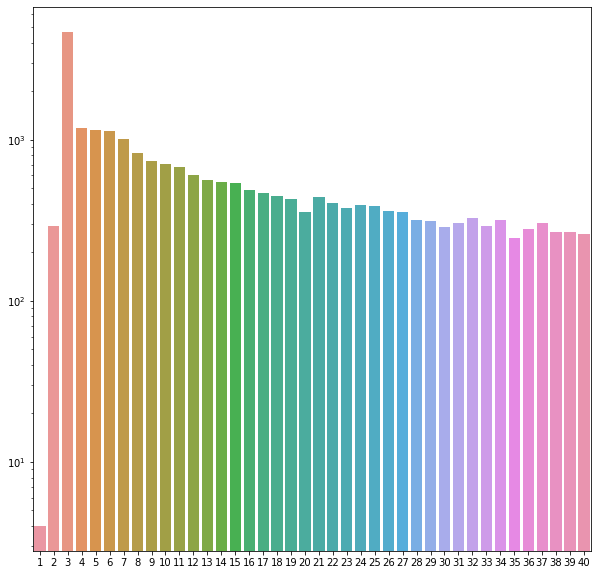

In [85]:
a,b = np.unique(alternate, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax=sns.barplot(x=a[:40],y=b[:40], ci=None, ax=ax)
ax.set_yscale('log')

In [88]:
len(alternate[alternate>2]) / len(alternate) 

0.9917292598531522

In [89]:
len(alternate[alternate>3]) / len(alternate) 

0.8605226882718654

array([ True,  True,  True, ...,  True,  True, False])

In [104]:
onlyinnew = newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]
highconf = onlyinnew[(onlyinnew['CGA_WES_AC'].str.split(':').str[0].values.astype(int)>3) & (onlyinnew['PERC_CGA_WES_AC'].values.astype(float)>0.3)]

In [105]:
len(highconf)/len(onlyinnew)

0.5861535431963316

In [106]:
newmutations

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,CGA_WES_AC,PERC_CGA_WES_AC,MAX_AF,PERC_PERC_CGA_WES_AC,INCLUDE,grouped
189786,VPS13D,55187,__UNKNOWN__,1,12359347,12359347,__UNKNOWN__,Nonsense_Mutation,SNP,C,...,NaN,False,0.0,NaN,34:213,0.137652,0.5,0.5,True,ACH-000001_1:12359347-12359347
959813,AADACL4,343066,__UNKNOWN__,1,12726308,12726322,__UNKNOWN__,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,NaN,False,3.0,NaN,57:141,0.287879,0.5,0.5,True,ACH-000001_1:12726308-12726322
189787,IFNLR1,163702,__UNKNOWN__,1,24484172,24484172,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,NaN,118:0,1.000000,1.0,0.5,True,ACH-000001_1:24484172-24484172
189788,ZSCAN20,7579,__UNKNOWN__,1,33954141,33954141,__UNKNOWN__,Missense_Mutation,SNP,T,...,NaN,False,0.0,NaN,28:62,0.311111,0.5,0.5,True,ACH-000001_1:33954141-33954141
189789,GBP4,115361,__UNKNOWN__,1,89657103,89657103,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,0.000016,96:0,1.000000,1.0,0.5,True,ACH-000001_1:89657103-89657103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901963,CYLC1,1538,__UNKNOWN__,X,83126495,83126495,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,34:38,0.472222,0.5,0.5,True,ACH-003000_X:83126495-83126495
901964,COL4A6,1288,__UNKNOWN__,X,107400439,107400439,__UNKNOWN__,Missense_Mutation,SNP,A,...,NaN,False,0.0,NaN,59:0,1.000000,1.0,0.5,True,ACH-003000_X:107400439-107400439
901965,COL4A5,1287,__UNKNOWN__,X,107821607,107821607,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,95:0,1.000000,1.0,0.5,True,ACH-003000_X:107821607-107821607
901966,GPR112,139378,__UNKNOWN__,X,135426613,135426613,__UNKNOWN__,Missense_Mutation,SNP,A,...,NaN,False,0.0,NaN,48:0,1.000000,1.0,0.5,True,ACH-003000_X:135426613-135426613


In [127]:
def filterCoverage(maf, loc=['CGA_WES_AC'], sep=':',cov=4):
    muts=np.zeroes((len(maf),2))
    for val in loc:
        muts+= np.array([[v[0],0] if 'NA' in v else v for v in mutations_20Q2_all[val].fillna('0'+sep+'0').astype(str).str.split(sep).tolist()]).astype(int)
    return maf[muts[:,1]>=cov]

def filterAllelicFraction(maf, loc=['CGA_WES_AC'], sep=':',frac=0.3):
    muts=np.zeroes((len(maf),2))
    for val in loc:
        muts+= np.array([[v[0],0] if 'NA' in v else v for v in mutations_20Q2_all[val].fillna('0'+sep+'0').astype(str).str.split(sep).tolist()]).astype(int)
    muts = muts[:,0]/muts[:,1]
    return maf[muts>=frac]

def mergeAnnotations(newmaf, additionalmaf):
    

def addAnnotation(maf):
    

def mafToMat(maf, col, boolify = False, samplesCol = "DepMap_ID", mutNameCol="Hugo_Symbol"):
    maf = maf.sort_values(by = mutNameCol)
    mut = pd.DataFrame(data = np.zeroes((len(set(maf[mutNameCol])), 1)), columns=['fake'], index=set(maf[mutNameCol])).astype(float)
    for val in set(maf[samplesCol]):
        mut.append(maf[maf[samplesCol]==val], axis=)
    return mut.nan_to_num(0).astype(bool if boolify else float).drop(columns=['fake'])
    

In [ ]:
filtered_mutations = filterCoverage(mutations)
filtered_mutations = filterAllelicFraction(filtered_mutations)

merged_mutations = addAnnotation(mutations)

mafToMat(filtered_mutations[filtered_mutations.damaging]).to_csv('.csv')
mafToMat(filtered_mutations[filtered_mutations.other]).to_csv('.csv')
mafToMat(filtered_mutations[filtered_mutations.hotspot]).to_csv('.csv')


CCLE2othermutations = 

mutations = mergeAnnotations(filtered_mutations, CCLE2othermutations)

#making 
for muttype in ['']:
    mafToMat(CCLE2othermutations[CCLE2othermutations.damaging & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")
    mafToMat(CCLE2othermutations[CCLE2othermutations.other & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")
    mafToMat(CCLE2othermutations[CCLE2othermutations.hotspot & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")

## DMC

In [ ]:
os.system('cd ../depmap-release-readmes && git pull && mv release-'+releAse+'/dmc-'+releAse+'.txt ../ccle_processing/temp/README && cd -')

In [9]:
print(len(mutations))
mutations = mutations[~mutations.DepMap_ID.isin(wes_embargo)]
print(len(mutations))
mutations.to_csv('temp/depmap_'+release+'_mutation_calls.all', index=False)
print(len(damaging_mutation))
damaging_mutation = damaging_mutation[~damaging_mutation.index.isin(wes_embargo)]
print(len(damaging_mutation))
damaging_mutation.to_csv('temp/damaging_mutation.all')
print(len(other_mutation))
other_mutation = other_mutation[~other_mutation.index.isin(wes_embargo)]
print(len(other_mutation))
other_mutation.to_csv('temp/other_mutation.all',)
print(len(hotspot_mutation))
hotspot_mutation = hotspot_mutation[~hotspot_mutation.index.isin(wes_embargo)]
print(len(hotspot_mutation))
hotspot_mutation.to_csv('temp/hotspot_mutation.all',)

1301656
1297418
1757
1744
1758
1745
1725
1712


In [12]:
prevmut = tc.get(name='depmap-mutation-calls-dfce', version=15, file='depmap_'+prevname+'_mutation_calls')
print('shoud be None')
print(set(prevmut.DepMap_ID) - set(mutations.DepMap_ID))
print("new lines")
newlines = set(mutations.DepMap_ID) - set(prevmut.DepMap_ID) 
newlines

[##################]100% |  40.4 MiB/s | 277.3 MiB / 277.3 MiB | Time:  0:00:06


shoud be None
set()
new lines


{'ACH-001533', 'ACH-001574', 'ACH-002021', 'ACH-002065'}

In [ ]:
tc.update_dataset(dataset_permaname="depmap-mutation-calls-dfce",
                 upload_file_path_dict={'temp/depmap_'+release+'_mutation_calls.all': 'TableCSV',
                                        'temp/damaging_mutation.all': 'NumericMatrixCSV',
                                        'temp/other_mutation.all': 'NumericMatrixCSV',
                                        'temp/hotspot_mutation.all': 'NumericMatrixCSV',
                                       },#'temp/README': 'Raw'},
                 dataset_description="""
# DMC Mutations

* Version 1-5 DMC 19Q1*

version 5 is a one-off portal thing because dmc wanted to be able to plot if a gene has any mutation as one-hot encoded value in the x/y axes of the data explorer It adds the any_mutation matrix, but does not change the others. Code used to generate:

```
from taigapy import TaigaClient

c = TaigaClient()

dmc_19q1_mutation_taiga_root = "depmap-mutation-calls-dfce.3/"
other_matrix = c.get(dmc_19q1_mutation_taiga_root + "other_mutation")
damaging_matrix = c.get(dmc_19q1_mutation_taiga_root + "damaging_mutation")
hotspot_matrix = c.get(dmc_19q1_mutation_taiga_root + "hotspot_mutation")

df = other_matrix.append(damaging_matrix)
df = df.groupby(level=0).sum()

df = df.append(hotspot_matrix)
df = df.groupby(level=0).sum()

df[df > 1] = 1

df.to_csv('any_mutation.csv')
```
The code uses version 3 because the dmc portal was using version 3

version 4 updates the column name from VA_WES_AC to CCLE_WES_AC

version 3 has an updated definition for hotspot mutations

version 2+ contains the correct data for 19Q1

* Version 6 DMC 19Q2*

* Version 7-8 DMC 19Q3*
version 8 fixed entrez ids

* Version 9 DMC 19Q4*
adding 52 new cell lines.

* Version 10 DMC 19Q4*
removing unauthorized lines and setting as matrices

* Version 11 DMC 19Q4*
removing unauthorized lines and setting as matrices

* Version 12 Internal 20Q1*
uploading 8 new lines

* Version 13 Internal 20Q1*
removing unauthorized cl

* Version 14 Internal 20Q2*
uploading 8 new lines and adding .all to express the fact that this data is the aggregate of all different sequencing methods.

* Version 15 Internal 20Q2*
removing 2 lines

* Version 15 Internal 20Q3*
nothing different from 20Q2. no new cell lines

* Version 15 Internal 20Q3*
updating the blacklists


MAF file, added column (Variant_annotation) classifying each variant as either silent, damaging, other conserving, or other non-conserving, based on this mapping (old annotation from Variant_Classification column - new annotation):

Silent - silent
Splice_Site - damaging
Missense_Mutation - other non-conserving
Nonsense_Mutation - damaging
De_novo_Start_OutOfFrame - damaging
Nonstop_Mutation - other non-conserving
Frame_Shift_Del - damaging
Frame_Shift_Ins - damaging
In_Frame_Del - other non-conserving
In_Frame_Ins - other non-conserving
Stop_Codon_Del - other non-conserving
Stop_Codon_Ins - other non-conserving
Start_Codon_SNP - damaging
Start_Codon_Del - damaging
Start_Codon_Ins - damaging
5'Flank - other conserving
Intron - other conserving
IGR - other conserving
3'UTR - other conserving
5'UTR - other conserving
Binary matrices:
- damaging: if damaging
- other: if other conserving or other non-conserving
- hotspot: if it is not a silent mutation and is either TCGA or COSMIC hotspot
- Rows: cell line, DepMap (arxspan) IDs

Columns: Gene, HGNC symbol (Entrez ID)

NEW LINES:
"""+newlines)

In [ ]:
# To add to a virtual dataset
AddToVirtual(virtual_dmc, 'depmap-mutation-calls-dfce', [('CCLE_mutations', 'depmap_'+release+'_mutation_calls'),])#('README','README')])

## Public

In [ ]:
os.system('cd ../depmap-release-readmes && git pull && mv release-'+releAse+'/public-'+releAse+'.txt README && cd -')

In [27]:

#damaging_mutation
mutations=depmap_20Q3_mutation_calls
#hotspot_mutation
#other_mutation

In [35]:
print(len(mutations))
mutations = mutations[mutations.DepMap_ID.isin(prevprev)]
mutations = mutations[~mutations.DepMap_ID.isin(wes_dmc_embargo)]
print(len(mutations))
mutations.to_csv('temp/depmap_'+release+'_mutation_calls.all', index=False)
print(len(damaging_mutation))
damaging_mutation = damaging_mutation[damaging_mutation.index.isin(prevprev)]
damaging_mutation = damaging_mutation[~damaging_mutation.index.isin(wes_dmc_embargo)]
print(len(damaging_mutation))
damaging_mutation.to_csv('temp/damaging_mutation.all')
print(len(other_mutation))
other_mutation = other_mutation[other_mutation.index.isin(prevprev)]
other_mutation = other_mutation[~other_mutation.index.isin(wes_dmc_embargo)]
print(len(other_mutation))
other_mutation.to_csv('temp/other_mutation.all')
print(len(hotspot_mutation))
hotspot_mutation = hotspot_mutation[hotspot_mutation.index.isin(prevprev)]
hotspot_mutation = hotspot_mutation[~hotspot_mutation.index.isin(wes_dmc_embargo)]
print(len(hotspot_mutation))
hotspot_mutation.to_csv('temp/hotspot_mutation.all')

1297418
1297418
1744
1744
1745
1745
1712
1712


In [36]:
prevmut = tc.get(name='depmap-mutation-calls-9a1a', version=18, file='depmap_'+prevname+'_mutation_calls')
print('shoud be None')
ermgency_removed = set(prevmut.DepMap_ID) - set(mutations.DepMap_ID)
print(ermgency_removed) 
print("new lines")
newlines = set(mutations.DepMap_ID) - set(prevmut.DepMap_ID) 
newlines

shoud be None
set()
new lines


{'ACH-001533', 'ACH-001574', 'ACH-002021', 'ACH-002065'}

In [38]:
description="""
# Public Mutations

Mutation calls for Public DepMap data

* Version 1 Public 18Q1*

original source: CCLE data portal
* Version 2 Public 18Q2*

merged mutations and indels file (1,549 cell lines total, including data for 63 newly released cell lines)
original source: `/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_maf_20180502.txt`
* Version 3-4 Public 18Q3*

version 3 deprecated

original source: `/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_maf_20180718.txt`

Binary matrices:
damaging: if isDeleterious is true
missense: if isDeleterious is false
hotspot: if missense and either TCGA or COSMIC hotspot
Rows: cell line, Broad (arxspan) IDs

Columns: Gene, HGNC symbol (Entrez ID)

MAF file

* Version 5 Public 18Q4*

original source: `/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_maf_20181029.txt`

* Version 6-9 Public 19Q1*

version 9 updates the column name from VA_WES_AC to CCLE_WES_AC

version 8 uses an updated definition for hotspot mutations

version 9 contains the correct data for 19Q1

* Version 10 Public 19Q2*

* Version 11-12 Public 19Q3*

version 12 fixed entrez ids

* Version 13 Public 19Q4*

adding 52 new cell lines

* Version 14 Public 19Q4*
removing unauthorized lines and setting matrices

* Version 15 Public 20Q1*
adding 8 new lines 

* Version 16 Public 20Q1*
removing an unauthorized line

* Version 17 Internal 20Q2*
uploading 8 new lines and adding .all to express the fact that this data is the aggregate of all different sequencing methods.

* Version 18 Internal 20Q2*
removing 2 lines

* Version 19 Internal 20Q3*
nothing different from 20Q2. no new cell lines

* Version 20 Internal 20Q3*
updating the blacklists

* Version 21 Internal 20Q3*
updating the dmc

* Version 22 Internal 20Q3*
readding two already released samples to the public list

MAF file, added column (Variant_annotation) classifying each variant as either silent, damaging, other conserving, or other non-conserving, based on this mapping (old annotation from Variant_Classification column - new annotation):

Silent - silent
Splice_Site - damaging
Missense_Mutation - other non-conserving
Nonsense_Mutation - damaging
De_novo_Start_OutOfFrame - damaging
Nonstop_Mutation - other non-conserving
Frame_Shift_Del - damaging
Frame_Shift_Ins - damaging
In_Frame_Del - other non-conserving
In_Frame_Ins - other non-conserving
Stop_Codon_Del - other non-conserving
Stop_Codon_Ins - other non-conserving
Start_Codon_SNP - damaging
Start_Codon_Del - damaging
Start_Codon_Ins - damaging
5'Flank - other conserving
Intron - other conserving
IGR - other conserving
3'UTR - other conserving
5'UTR - other conserving
Binary matrices:

- damaging: if damaging
- other: if other conserving or other non-conserving
- hotspot: if it is not a silent mutation and is either TCGA or COSMIC hotspot
- Rows: cell line, DepMap (arxspan) IDs

Columns: Gene, HGNC symbol (Entrez ID)

NEW LINES:
"""+str(newlines)

if len(ermgency_removed):
    description+="""
    
    !! WE REMOVED!!:
    """+str(ermgency_removed)

tc.update_dataset(dataset_permaname="depmap-mutation-calls-9a1a",
                 upload_file_path_dict={'temp/depmap_'+release+'_mutation_calls.all': 'TableCSV',
                                        'temp/damaging_mutation.all': 'NumericMatrixCSV',
                                        'temp/other_mutation.all': 'NumericMatrixCSV',
                                        'temp/hotspot_mutation.all': 'NumericMatrixCSV',
                                       },#'temp/README': 'Raw'},
                 dataset_description=description)

Uploading depmap_20Q3_mutation_calls...
hitting https://cds.team/taiga/api/datafile/00b151ca35a14f6d9f1be95ef24ea368
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: depmap_20Q3_mutation

'8cc4900a50874d8593b0bfc591001360'

In [ ]:
# To add to a virtual dataset
AddToVirtual(virtual_public, 'depmap-mutation-calls-9a1a', [('CCLE_mutations', 'depmap_'+release+'_mutation_calls'),])#('README','README')])

[('CCLE_mutations', 'depmap-mutation-calls-9a1a.22/depmap_20Q3_mutation_calls'), ('CCLE_gene_cn', 'depmap-wes-cn-data-97cc.34/public_20Q3_gene_cn'), ('Achilles_gene_effect_unscaled', 'avana-public-tentative-20q3-3e73.5/gene_effect_unscaled'), ('Achilles_high_variance_genes', 'avana-public-tentative-20q3-3e73.5/high_variance_genes'), ('Achilles_guide_efficacy', 'avana-public-tentative-20q3-3e73.5/guide_efficacy'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.14/unfiltered_fusions_20Q3'), ('common_essentials', 'avana-public-tentative-20q3-3e73.5/essential_genes'), ('Achilles_logfold_change_failures', 'avana-public-tentative-20q3-3e73.5/logfold_change_failures'), ('CCLE_expression', 'depmap-rnaseq-expression-data-ccd0.25/public_20Q3_proteincoding_tpm'), ('Achilles_raw_readcounts', 'avana-public-tentative-20q3-3e73.5/raw_readcounts'), ('Achilles_raw_readcounts_failures', 'avana-public-tentative-20q3-3e73.5/raw_readcounts_failing'), ('README', 'public-20q3-3d35.22/README'), ('CCLE_segment